In [1]:
import os
import json
import time
import logging
from copy import deepcopy
from dotenv import load_dotenv
import nest_asyncio
from typing import Optional

from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient

from llama_index.core import StorageContext, VectorStoreIndex, SimpleDirectoryReader
from llama_index.core.schema import TextNode, ImageNode, NodeWithScore, MetadataMode
from llama_index.core.settings import Settings
from llama_index.core.query_engine import CustomQueryEngine, SimpleMultiModalQueryEngine
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.prompts import PromptTemplate
from llama_index.core.base.response.schema import Response
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.vector_stores.azureaisearch import AzureAISearchVectorStore, IndexManagement, MetadataIndexFieldType
import os
import asyncio
from azure.storage.blob.aio import BlobServiceClient
from dotenv import load_dotenv
from llama_parse import LlamaParse
import re
from copy import deepcopy
from typing import Dict, List
from llama_index.core.schema import TextNode, MetadataMode
import nest_asyncio
from llama_index.multi_modal_llms.azure_openai import AzureOpenAIMultiModal
# Example usage of MultimodalQueryEngine
from llama_index.core.response.notebook_utils import display_response, display_query_and_multimodal_response, display_source_node
from llama_index.core.schema import MetadataMode
from llama_index.core.vector_stores.types import VectorStoreQueryMode


# Apply nest_asyncio to avoid asyncio errors in notebooks
nest_asyncio.apply()

In [2]:
# Environment Variables
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME")
AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME")
SEARCH_SERVICE_ENDPOINT = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
SEARCH_SERVICE_API_KEY = os.getenv("AZURE_SEARCH_ADMIN_KEY")
INDEX_NAME = "llamaindex-azure-aisearch-rag"

# Initialize LLM and Embedding models
llm = AzureOpenAI(
    engine=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-08-01-preview"
)

embed_model = AzureOpenAIEmbedding(
    engine=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    model=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-08-01-preview"
)

Settings.llm = llm
Settings.embed_model = embed_model

# Initialize search clients
credential = AzureKeyCredential(SEARCH_SERVICE_API_KEY)
index_client = SearchIndexClient(endpoint=SEARCH_SERVICE_ENDPOINT, credential=credential)
search_client = SearchClient(endpoint=SEARCH_SERVICE_ENDPOINT, index_name=INDEX_NAME, credential=credential)

### Document Processing and Image Extraction

In [3]:
# Azure Blob Configuration
BLOB_CONNECTION_STRING = os.getenv("BLOB_CONNECTION_STRING")
BLOB_STORAGE_ACCOUNT_KEY = os.getenv("BLOB_STORAGE_ACCOUNT_KEY")
BLOB_CONTAINER_NAME = "multimodal"

LLAMA_PARSE_API_KEY = os.getenv("LLAMA_PARSE_API_KEY")

# Set up download path and parser
DOWNLOAD_PATH = "data_images"
os.makedirs(DOWNLOAD_PATH, exist_ok=True)

parser = LlamaParse(
    result_type="markdown",
    api_key=LLAMA_PARSE_API_KEY,
    use_vendor_multimodal_model=True,
    azure_openai_endpoint=f"{AZURE_OPENAI_ENDPOINT}openai/deployments/{AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME}/chat/completions?api-version=2024-02-15-preview",
    azure_openai_api_version="2024-02-15-preview",
    azure_openai_key=AZURE_OPENAI_API_KEY,
    azure_openai_deployment_name=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME
)

# Parse document and extract images
md_json_objs = parser.get_json_result("report_2024.pdf")

print(md_json_objs)

md_json_list = md_json_objs[0]["pages"]
image_dicts = parser.get_images(md_json_objs, download_path=DOWNLOAD_PATH)

Started parsing the file under job_id 46ef19f3-0824-4332-acfb-05d948715a99
[{'pages': [{'page': 1, 'md': '# STATE OF AI REPORT\n\nOctober 10, 2024\n\nNathan Benaich\n\nAIR STREET CAPITAL\n\nstateof.ai | airstreet.com', 'images': [{'name': 'page_1.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}], 'charts': [], 'items': [{'type': 'heading', 'lvl': 1, 'value': 'STATE OF AI REPORT', 'md': '# STATE OF AI REPORT'}, {'type': 'text', 'value': 'October 10, 2024\n\nNathan Benaich\n\nAIR STREET CAPITAL\n\nstateof.ai | airstreet.com', 'md': 'October 10, 2024\n\nNathan Benaich\n\nAIR STREET CAPITAL\n\nstateof.ai | airstreet.com'}], 'status': 'OK', 'links': [], 'triggeredAutoMode': False, 'structuredData': None, 'noStructuredContent': False, 'noTextContent': False}, {'page': 2, 'md': "# Follow our writing on AIR STREET PRESS (press.airstreet.com)\n\n> If you enjoy reading the State of AI Report, we invite you to read and subscribe to Air Street Press, the home of our a

### Asynchronous Image Upload to Azure Blob Storage


In [4]:
# Limit the number of concurrent uploads
CONCURRENT_UPLOADS = 5

async def create_container_if_not_exists(connection_string: str, container_name: str):
    """Create container if it doesn't exist, handling the operation once."""
    blob_service_client = BlobServiceClient.from_connection_string(connection_string)
    async with blob_service_client:
        container_client = blob_service_client.get_container_client(container_name)
        if not await container_client.exists():
            try:
                await container_client.create_container()
                print(f"Container {container_name} created successfully")
            except Exception as e:
                print(f"Error creating container: {e}")

async def upload_image_to_blob_storage(image, blob_name, semaphore):
    """Upload a single image to blob storage."""
    async with semaphore:
        try:
            image_path = image.get('path') or image.get('original_file_path')
            if not image_path or not os.path.exists(image_path):
                print(f"Image path not found or invalid: {image_path}")
                return None

            blob_service_client = BlobServiceClient.from_connection_string(BLOB_CONNECTION_STRING)
            async with blob_service_client:
                container_client = blob_service_client.get_container_client(BLOB_CONTAINER_NAME)
                blob_client = container_client.get_blob_client(blob_name)

                with open(image_path, "rb") as f:
                    await blob_client.upload_blob(f, overwrite=True)
                    print(f"Successfully uploaded {blob_name}")
                return blob_client.url

        except Exception as e:
            print(f"Failed to upload {blob_name}: {str(e)}")
            return None

async def main():
    """Main function to handle container creation and image uploads."""
    # First, ensure the container exists
    await create_container_if_not_exists(BLOB_CONNECTION_STRING, BLOB_CONTAINER_NAME)
    
    # Then proceed with uploads
    semaphore = asyncio.Semaphore(CONCURRENT_UPLOADS)
    upload_tasks = [upload_image_to_blob_storage(image, image["name"], semaphore) 
                   for image in image_dicts]
    
    results = await asyncio.gather(*upload_tasks)
    
    # Create dictionary of successful uploads
    successful_uploads = {
        image["name"]: url
        for image, url in zip(image_dicts, results)
        if url is not None
    }
    
    # Print summary
    print(f"\nUpload Summary:")
    print(f"Total images: {len(image_dicts)}")
    print(f"Successfully uploaded: {len(successful_uploads)}")
    print(f"Failed uploads: {len(image_dicts) - len(successful_uploads)}")
    
    return successful_uploads

# Run the main function
image_urls = asyncio.run(main())

Container multimodal created successfully
Successfully uploaded page_1.jpg
Successfully uploaded page_2.jpg
Successfully uploaded page_4.jpg
Successfully uploaded page_3.jpg
Successfully uploaded page_5.jpg
Successfully uploaded page_10.jpg
Successfully uploaded page_8.jpg
Successfully uploaded page_6.jpg
Successfully uploaded page_7.jpg
Successfully uploaded page_9.jpg
Successfully uploaded page_12.jpg
Successfully uploaded page_11.jpg
Successfully uploaded page_13.jpg
Successfully uploaded page_14.jpg
Successfully uploaded page_15.jpg
Successfully uploaded page_17.jpg
Successfully uploaded page_16.jpg
Successfully uploaded page_19.jpg
Successfully uploaded page_18.jpg
Successfully uploaded page_20.jpg
Successfully uploaded page_23.jpg
Successfully uploaded page_21.jpg
Successfully uploaded page_22.jpg
Successfully uploaded page_25.jpg
Successfully uploaded page_24.jpg
Successfully uploaded page_27.jpg
Successfully uploaded page_28.jpg
Successfully uploaded page_26.jpg
Successfully up

### Text Node Creation


In [5]:
def get_page_number(file_name: str) -> int:
    """Extract page number from blob name."""
    match = re.search(r"page_(\d+)\.jpg$", str(file_name))
    if match:
        return int(match.group(1))
    return 0

def _get_sorted_blob_urls(image_urls: Dict[str, str]) -> List[str]:
    """Get blob URLs sorted by page number."""
    sorted_items = sorted(image_urls.items(), key=lambda x: get_page_number(x[0]))
    return [url for _, url in sorted_items]

def get_text_nodes(image_urls: Dict[str, str], json_dicts: List[dict]) -> List[TextNode]:
    """Create TextNodes with metadata including blob URLs as image_path."""
    nodes = []
    
    sorted_urls = _get_sorted_blob_urls(image_urls)
    md_texts = [d["md"] for d in json_dicts]

    for idx, md_text in enumerate(md_texts):
        if idx >= len(sorted_urls):
            continue
            
        node = TextNode(
            text=md_text,
            metadata={
                "page_num": idx + 1,
                "image_path": sorted_urls[idx],
                "parsed_text_markdown": md_texts[idx],
            }
        )
        nodes.append(node)

    return nodes

# Create text nodes
text_nodes = get_text_nodes(image_urls=image_urls, json_dicts=md_json_list)

# Print an example node to verify
print(text_nodes[0].get_content(metadata_mode=MetadataMode.ALL))

page_num: 1
image_path: https://ste5jpmbwowqvuu.blob.core.windows.net/multimodal/page_1.jpg
parsed_text_markdown: # STATE OF AI REPORT

October 10, 2024

Nathan Benaich

AIR STREET CAPITAL

stateof.ai | airstreet.com

# STATE OF AI REPORT

October 10, 2024

Nathan Benaich

AIR STREET CAPITAL

stateof.ai | airstreet.com


### Vector Store Integration


In [7]:
# Define metadata fields mapping
metadata_fields = {
    "page_num": ("page_num", MetadataIndexFieldType.INT64),
    "image_path": ("image_path", MetadataIndexFieldType.STRING),
    "parsed_text_markdown": ("parsed_text_markdown", MetadataIndexFieldType.STRING),
}

def create_vector_store(
    index_client,
    index_name: str,
    use_existing_index: bool = False
) -> AzureAISearchVectorStore:
    """Create or get existing Azure AI Search vector store."""
    return AzureAISearchVectorStore(
        search_or_index_client=index_client,
        index_name=index_name,
        index_management=IndexManagement.VALIDATE_INDEX if use_existing_index 
                        else IndexManagement.CREATE_IF_NOT_EXISTS,
        id_field_key="id",
        chunk_field_key="parsed_text_markdown",
        embedding_field_key="embedding",
        embedding_dimensionality=3072,
        metadata_string_field_key="metadata",
        doc_id_field_key="doc_id",
        filterable_metadata_field_keys=metadata_fields,
        language_analyzer="en.lucene",
        vector_algorithm_type="exhaustiveKnn",
    )

def create_or_load_index(
    text_nodes,
    index_client,
    index_name: str,
    embed_model,
    llm,
    use_existing_index: bool = False
) -> VectorStoreIndex:
    """Create new index or load existing one."""
    vector_store = create_vector_store(index_client, index_name, use_existing_index)
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    
    if use_existing_index:
        return VectorStoreIndex.from_documents(
            [],
            storage_context=storage_context,
        )
    else:
        return VectorStoreIndex(
            nodes=text_nodes,
            storage_context=storage_context,
            embed_model=embed_model,
            llm=llm,
            show_progress=True,
        )

# Initialize vector store index
index = create_or_load_index(
    text_nodes=text_nodes,
    index_client=index_client,
    index_name=INDEX_NAME,
    embed_model=embed_model,
    llm=llm,
    use_existing_index=False
)

Generating embeddings:   0%|          | 0/213 [00:00<?, ?it/s]

### Custom Multmodal Query Engine

In [8]:
# Define QA prompt template
QA_PROMPT_TMPL = """\
Below we give parsed text from slides in parsed markdown format, as well as the image.

---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query. Explain whether you got the answer
from the parsed markdown or raw text or image, and if there's discrepancies, and your reasoning for the final answer.

Query: {query_str}
Answer: """

QA_PROMPT = PromptTemplate(QA_PROMPT_TMPL)


class MultimodalQueryEngine(CustomQueryEngine):
    """Custom multimodal Query Engine for public blob storage."""

    qa_prompt: PromptTemplate
    retriever: BaseRetriever
    multi_modal_llm: AzureOpenAIMultiModal

    def __init__(self, qa_prompt: Optional[PromptTemplate] = None, **kwargs) -> None:
        """Initialize."""
        super().__init__(qa_prompt=qa_prompt or QA_PROMPT, **kwargs)

    def custom_query(self, query_str: str) -> Response:
        # Retrieve relevant nodes
        nodes = self.retriever.retrieve(query_str)

        # Create ImageNode items directly using the blob URLs
        image_nodes = []
        for n in nodes:
            if "image_path" in n.metadata:
                try:
                    image_nodes.append(
                        NodeWithScore(
                            node=ImageNode(image_url=n.metadata["image_path"])
                        )
                    )
                except Exception as e:
                    print(
                        f"Warning: Failed to create ImageNode for {n.metadata['image_path']}: {str(e)}"
                    )
                    continue

        # Create context string from text nodes
        context_str = "\n\n".join(
            [node.get_content(metadata_mode=MetadataMode.LLM) for node in nodes]
        )

        # Format the prompt
        fmt_prompt = self.qa_prompt.format(context_str=context_str, query_str=query_str)
        # Get response from multimodal LLM
        llm_response = self.multi_modal_llm.complete(
            prompt=fmt_prompt,
            image_documents=[image_node.node for image_node in image_nodes],
        )

        return Response(
            response=str(llm_response),
            source_nodes=nodes,
            metadata={"text_nodes": nodes, "image_nodes": image_nodes},
        )


# Initialize GPT-4o multimodal model
azure_openai_mm_llm = AzureOpenAIMultiModal(
    engine=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_version="2024-08-01-preview",
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    max_new_tokens=4096,
    api_key=AZURE_OPENAI_API_KEY,
    api_base=AZURE_OPENAI_ENDPOINT,
)

# Create and initialize the query engine
query_engine = MultimodalQueryEngine(
    retriever=index.as_retriever(
        vector_store_query_mode=VectorStoreQueryMode.DEFAULT, similarity_top_k=3 # default is pure vector search, try HYBRID or SEMANTIC_HYBRID
    ),
    multi_modal_llm=azure_openai_mm_llm,
)

### Testing the System

Query: How did the CIFAR-10 and CIFAR-100 datasets perform using adversarial accuracy in different models, and how does this relate to the training improvements for MobileCLIP in terms of image-text pairing on smartphones?
Retrieved Images:



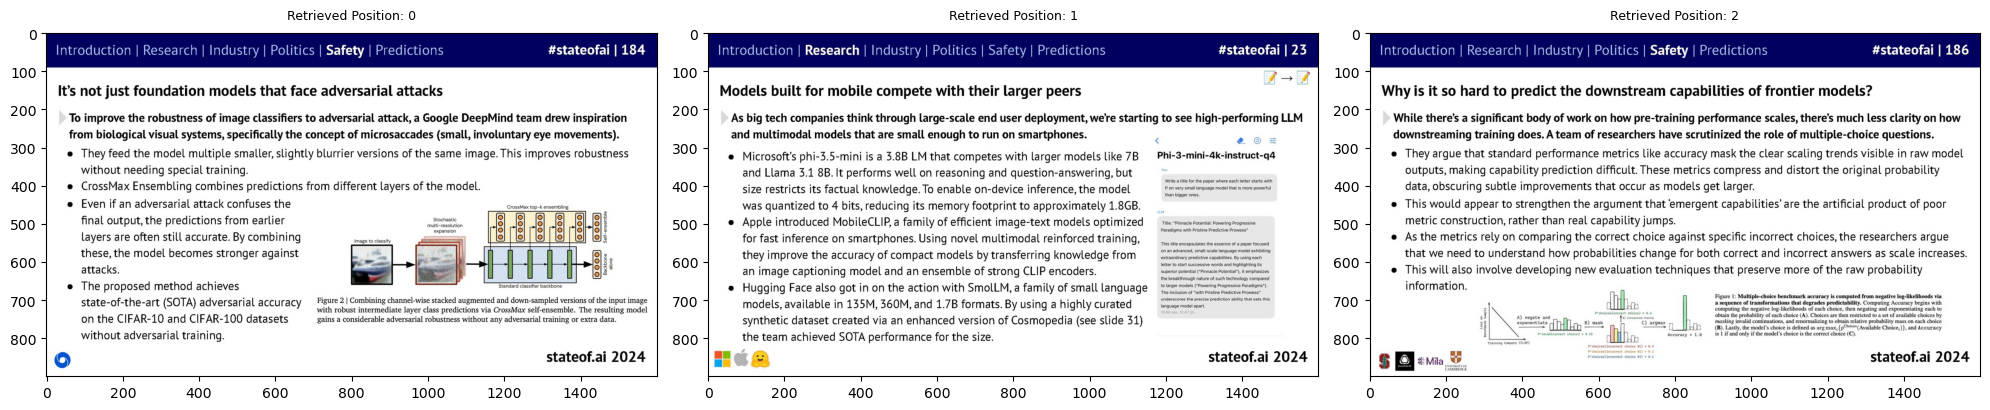

Response: The CIFAR-10 and CIFAR-100 datasets achieved state-of-the-art (SOTA) adversarial accuracy using the proposed method by the Google DeepMind team. This method involves feeding the model multiple smaller, slightly blurrier versions of the same image and combining predictions from different layers of the model (CrossMax Ensembling). This approach improves robustness against adversarial attacks without requiring special training.

In contrast, MobileCLIP, introduced by Apple, focuses on optimizing image-text models for fast inference on smartphones. MobileCLIP uses novel multimodal reinforced training to improve the accuracy of compact models by transferring knowledge from an image captioning model and an ensemble of strong CLIP encoders.

Both approaches aim to enhance model performance, but they address different challenges. The method for CIFAR-10 and CIFAR-100 focuses on improving adversarial robustness, while MobileCLIP aims to optimize image-text pairing for efficient on-dev

In [10]:
# Example query focused on visual and textual content
query = "How did the CIFAR-10 and CIFAR-100 datasets perform using adversarial accuracy in different models, and how does this relate to the training improvements for MobileCLIP in terms of image-text pairing on smartphones?"

# Execute the query
response = query_engine.query(query)

# Display the query and multimodal response
display_query_and_multimodal_response(query, response, 8, 20)

# Print source nodes for transparency
print("\nSource Nodes:")
for node in response.source_nodes:
    print("\nPage Number:", node.metadata["page_num"])
    print("Text Content Length:", len(node.text))

Query: What are the comparative benefits of using Sora's spacetime patches for video generation versus Veo's compressed video inputs in the diffusion process?
Retrieved Images:



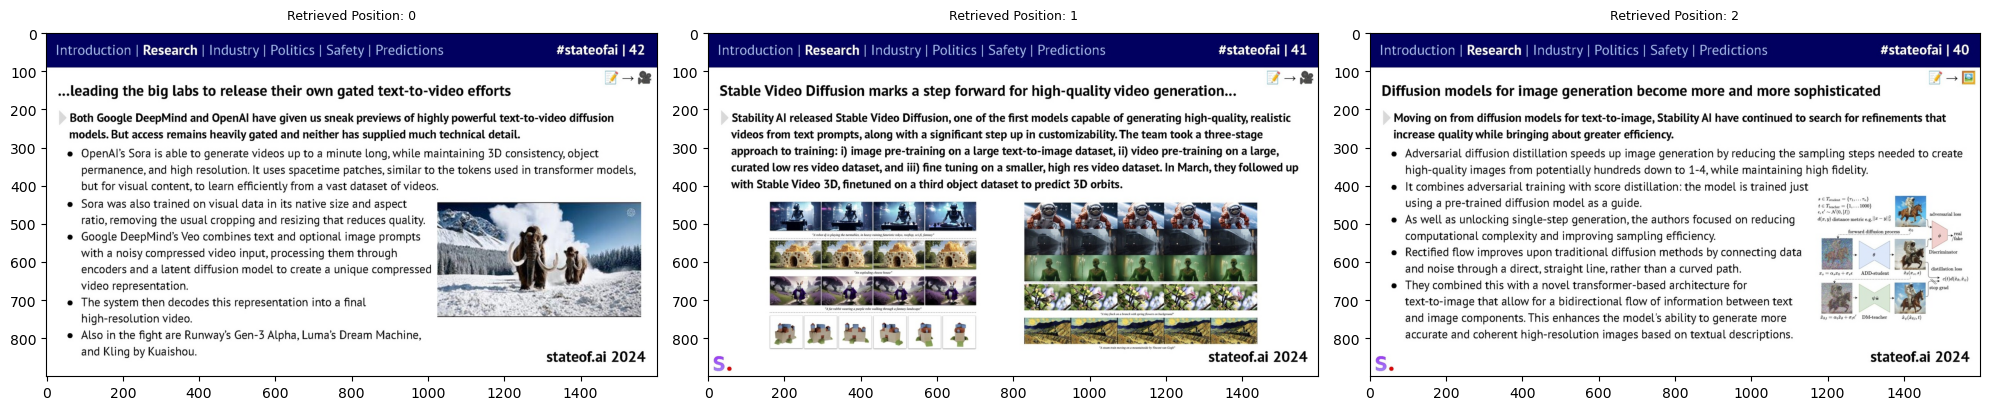

Response: The comparative benefits of using Sora's spacetime patches for video generation versus Veo's compressed video inputs in the diffusion process can be summarized as follows:

### Sora's Spacetime Patches:
1. **3D Consistency and Object Permanence**: Sora is able to maintain 3D consistency and object permanence in the generated videos.
2. **High Resolution**: The model generates high-resolution videos.
3. **Efficient Learning**: By using spacetime patches, similar to tokens in transformer models but for visual content, Sora can learn efficiently from a vast dataset of videos.
4. **Native Size and Aspect Ratio**: Sora is trained on visual data in its native size and aspect ratio, avoiding the usual cropping and resizing that can reduce quality.

### Veo's Compressed Video Inputs:
1. **Text and Image Prompts**: Veo can combine text and optional image prompts with a noisy compressed video input.
2. **Unique Compressed Video Representation**: The model processes inputs through encod

In [11]:
# Example query focused on visual and textual content
query = "What are the comparative benefits of using Sora's spacetime patches for video generation versus Veo's compressed video inputs in the diffusion process?"

# Execute the query
response = query_engine.query(query)

# Display the query and multimodal response
display_query_and_multimodal_response(query, response, 8, 20)

# Print source nodes for transparency
print("\nSource Nodes:")
for node in response.source_nodes:
    print("\nPage Number:", node.metadata["page_num"])
    print("Text Content Length:", len(node.text))